In [23]:
using Pkg
Pkg.add("ThreadsX")

using DrWatson
@quickactivate "generalized-marcenko-pastur"

using Distributions, RandomMatrixDistributions
using StatsBase, Statistics
using LinearAlgebra
using Plots
using ThreadsX
using HypergeometricFunctions
using NLsolve
using LaTeXStrings

   Resolving package versions...


  No Changes to `~/Library/CloudStorage/Dropbox/research/projects/generalized-marcenko-pastur/Project.toml`
  No Changes to `~/Library/CloudStorage/Dropbox/research/projects/generalized-marcenko-pastur/Manifest.toml`


# Marcenko-Pastur with tail dependencies

The $R$-transform of a Spearman correlation matrix in the large $N, T$ limit ($q = \lim N/T$) is given by 
$$
R(g) = \left\langle \frac{3s}{1 - 3g q s} \right\rangle_s\quad\textrm{where}\ s = \frac{1}{N} \sum_{i=1}^N \Vert (2F(X)-1)\Vert^2
$$
If $x_t^i = \sigma_t\xi^i_t$, then $s = \langle (2F(\sigma\xi)-1)^2\rangle_\xi.$

In the case where $ξ^i = ±1$ with equal probability, we find the super-universal density $P(s) = 1/(2\sqrt{s})$. Averaging over $s$ then gives
$$
R(g) = \frac{1}{qg}\left(\frac{\tanh^{-1}(\sqrt{3qg})}{\sqrt{3qg}} - 1\right).
$$

If we assume $s\sim \textrm{Beta}(α, 2α)$, we obtain
$$
R(g) = {}_2F_1(1, α + 1 ; 3α + 1; 3qg),
$$
which gives back the previous result when $\alpha = 1/2$. 

## Analytical

In [3]:
R₀(g; q = .5) = (atanh(sqrt(3*q*g))/sqrt(3*q*g) - 1)/(q*g)
R(g; q = .5, α = 1/2) = pFq([1, 1+α], [3α+1], 3*q*g)
B(g; kwargs...) = R(g; kwargs...) + 1/g 

B (generic function with 1 method)

In [4]:
function F(g, z; kwargs...)
    g = Complex(g...)
    return reim(g*R(g; kwargs...) - (z*g - 1))
end

gg(z; kwargs...) = Complex(nlsolve(g -> F(g, z; kwargs...), [.1, .1]).zero...)
ρ(λ; kwargs...) = (1/π) * imag(gg(λ + 1e-6*im; kwargs...))

ρ (generic function with 1 method)

In [5]:
Λ = 0:.01:5
analytical(; kwargs...) = ρ.(Λ; kwargs...)

analytical (generic function with 1 method)

### Binary $\xi$ 

In [85]:
function binary(; N = 100, q = .5, dist_sigma = Uniform(0, 1))
    T = Int(round(N/q))
    ξ = rand([-1, 1], (T, N))
    σ = rand(dist_sigma, T)
    X = ξ .* σ
    return X
end

function binary_spectrum(; replicates = 100, kwargs...)
    return ThreadsX.sum(eigvals(Symmetric(corspearman(binary(; kwargs...)))) for _ in 1:replicates) / replicates
end

binary_spectrum (generic function with 1 method)

In [86]:
evalues(q) = binary_spectrum(; q = q, N = 200, replicates = 100)

evalues (generic function with 1 method)

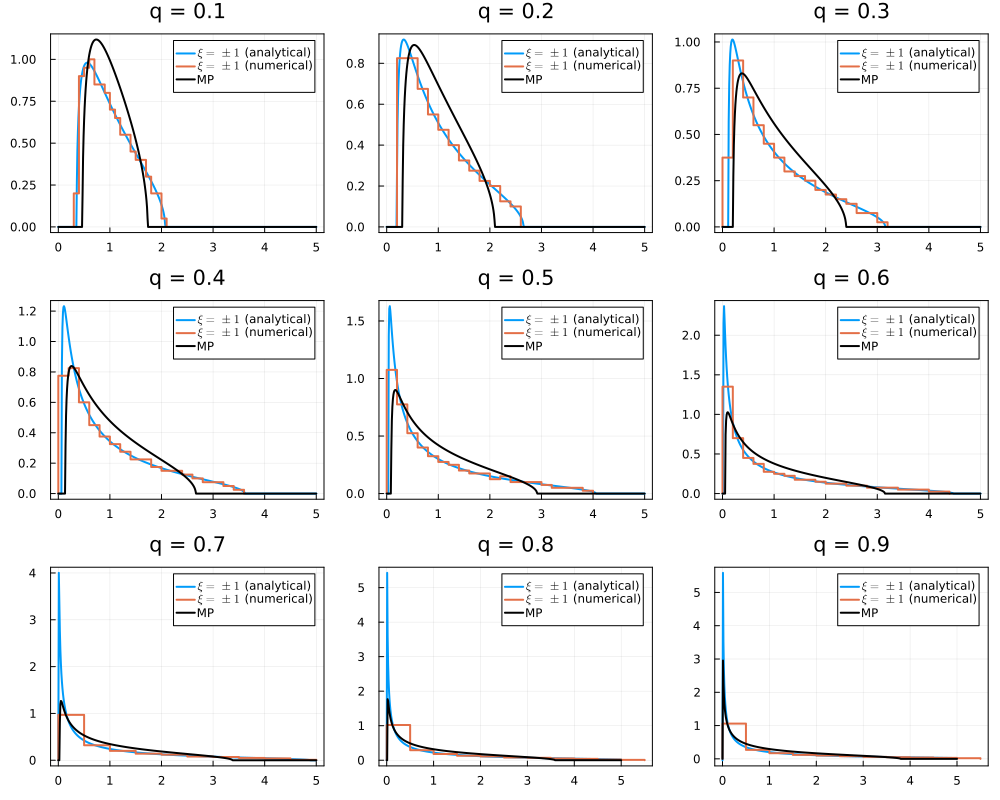

In [178]:
plots = []
for q in .1:.1:.9
    plot(Λ, analytical(q = q, α = 1/2), label = L"\xi = \pm 1" * " (analytical)", lw = 2)
    stephist!(evalues(q), label =  L"\xi = \pm 1" *" (numerical)", normalize = :pdf, bins = 20, lw = 2)
    plot!(Λ, pdf.(MarchenkoPastur(q), Λ), label = "MP", color = "black", lw = 2)
    title!("q = $q")
    push!(plots, current())
end
plot(plots..., layout = (3, 3), size = (1000, 800), legend = :topright, framestyle = :box)

### Multivariate Student

In [195]:
function student(; N = 100, q = .5, ν = 3)
    T = Int(round(N/q))
    X = rand(MvTDist(ν, zeros(N), Matrix(I(N))), T)'
end

function student_spectrum(; replicates = 100, kwargs...)
    return ThreadsX.sum(eigvals(Symmetric(corspearman(student(; kwargs...)))) for _ in 1:replicates) / replicates
end

student_spectrum (generic function with 1 method)

In [151]:
s(ν, N, T) = mapslices(row -> norm(row)^2/length(row), mapslices(col -> 2*tiedrank(col)/length(col) .- 1, student(ν = ν,  N = N, q = N/T) ,dims = 2), dims = 1)'

s (generic function with 2 methods)

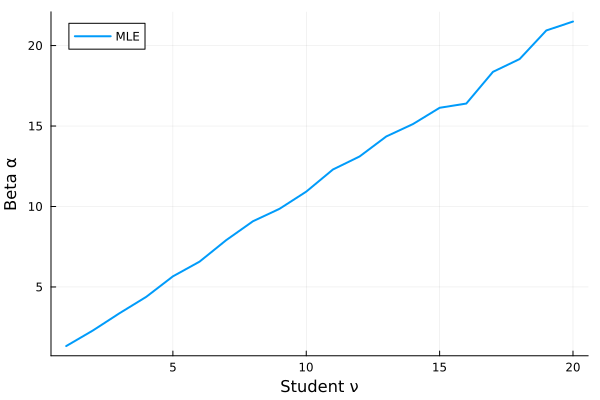

In [183]:
nu_range = 1:1:20
alpha_range = ThreadsX.map(ν -> fit_mle(Beta, s(ν, 1000, 5000)).α, nu_range)
plot(nu_range, alpha_range, lw = 2, label = "MLE", xlabel = "Student ν", ylabel = "Beta α")

In [197]:
evalues(ν, q; kwargs...) = student_spectrum(; ν = ν, q = q, kwargs...)

evalues (generic function with 2 methods)

In [198]:
evalues(2, .5, N = 50)

50-element Vector{Float64}:
 0.08514352596574938
 0.10659713819578999
 0.12564168181731467
 0.14637844390862068
 0.16551053905278829
 0.18634438554385377
 0.2066030485559969
 0.2270970827549477
 0.24977584399672514
 0.2733712455112811
 ⋮
 1.8336509970027453
 1.9258118692459936
 2.0374130415931546
 2.15517586941432
 2.2892351902842933
 2.443300415352934
 2.6066507401505383
 2.82967322710709
 3.150825275247692

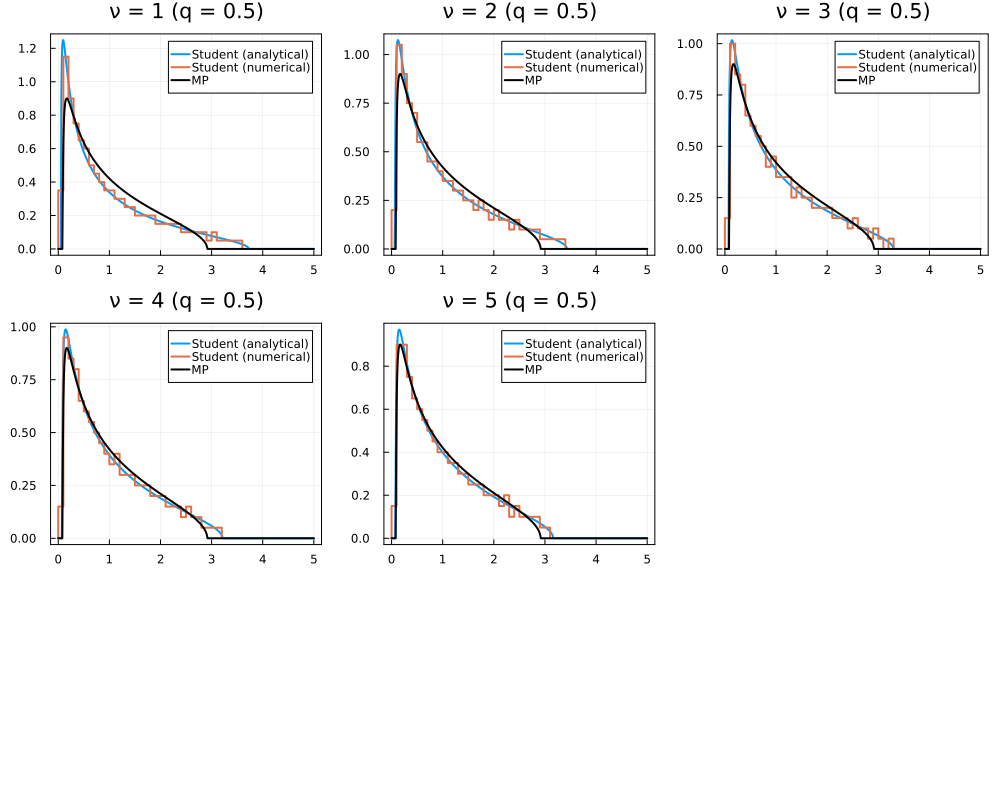

In [205]:
plots = []
q = .5
for ν in 1:1:5
    plot(Λ, analytical(q = q, α = ν), label = "Student (analytical)", lw = 2)
    stephist!(evalues(ν, q; N = 200, replicates = 500), label =  "Student (numerical)", normalize = :pdf, bins = 50, lw = 2)
    plot!(Λ, pdf.(MarchenkoPastur(q), Λ), label = "MP", color = "black", lw = 2)
    title!("ν = $ν (q = $q)")
    push!(plots, current())
end
plot(plots..., layout = (3, 3), size = (1000, 800), legend = :topright, framestyle = :box)

In [17]:
ν = 3
a = analytical(q = .5, α = ν)

501-element Vector{Float64}:
 -3.360849682694927e-6
 -3.925303114529297e-6
 -4.673388423963364e-6
 -5.739516086290031e-6
 -7.382446003703573e-6
 -1.0256459202329268e-5
 -1.6731737524084735e-5
 -5.1965194097645726e-5
  0.6024418503757174
  0.8206503757035031
  ⋮
 -2.4604643954895102e-8
 -2.4451444001730814e-8
 -2.4299809514496125e-8
 -2.414971715999349e-8
 -2.4001144076238872e-8
 -2.3854067860255166e-8
 -2.3708466556256866e-8
 -2.356431864420566e-8
 -2.3421603028725344e-8

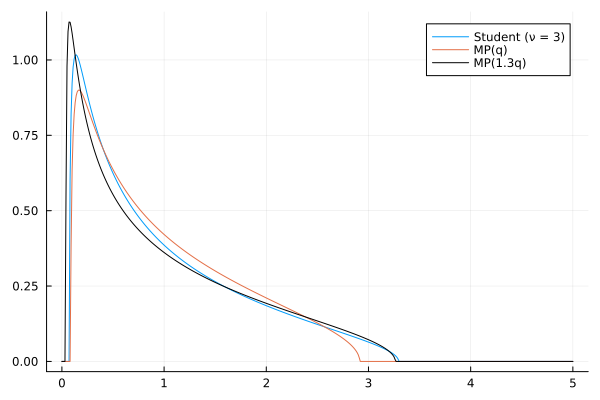

In [22]:
q = .5
plot(Λ, a, label = "Student (ν = $ν)")
plot!(Λ, pdf.(MarchenkoPastur(q), Λ), label = "MP(q)")
plot!(Λ, pdf.(MarchenkoPastur(1.3q), Λ), label = "MP(1.3q)", color = "black")